### **API SADVR - Portrait statistique**  
https://www.cen.umontreal.ca/espacedoc/sadvr/  

Ce NoteBook est destiné à l'extraction et la visualisation de statistiques relatives aux professeur·e·s et à leurs expertises à partir de l'API de la vitrine de la recherche (SADVR). 
Celles-ci seront intégrées en un tableau de bord [PowerBI](https://wiki.umontreal.ca/display/SIE/Power+BI) permettant d'avoir un portrait d'ensemble des données.  

---

In [29]:
from utils.sadvr_utils import *
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

data = updateInfoProfs()
expertises = data[['idsadvr', 'expertise']]

departements = getTable('individus')[['idsadvr', 'uniteAdmin']]

expertises = expertises.merge(departements, on='idsadvr')

expertises['département'] = expertises['uniteAdmin'].astype(str).apply(uniteAdminDepartement)
expertises = expertises.drop(columns='uniteAdmin')


## Normalisation des données
toNormalize = ['expertise', 'expertise.disciplines']
for c in toNormalize:
    expertises = explodeNormalize(expertises, c)

expertises = expertises.dropna(subset = 'expertise.disciplines.uid') 
expertises = expertises[expertises['expertise.motsCles'].astype(str) != '[]']
expertises = expertises[expertises['département'].astype(str) != 'None']

expertises = explodeNormalize(expertises, 'expertise.motsCles')

expertises = expertises[['idsadvr', 'département',
      'expertise.disciplines.uid', 'expertise.disciplines.codeLangue','expertise.disciplines.nom', 
       'expertise.motsCles.uid', 'expertise.motsCles.nom', 'expertise.motsCles.codeLangue']]

expertises = expertises.sort_values(by=[
    f'expertise.disciplines.uid', f'expertise.disciplines.codeLangue',
    f'expertise.motsCles.uid', f'expertise.motsCles.codeLangue'], ascending=[True, False, True, False])

expertises = expertises.drop_duplicates(subset=['idsadvr', 'expertise.motsCles.uid', 'expertise.disciplines.uid'])
expertises = expertises.drop(columns=['expertise.disciplines.codeLangue', 'expertise.motsCles.codeLangue'])

## Extraire les fréquences associées aux disciplines et aux mots-clés: elles vont permettre d'assigner
# une taille aux noeuds dans le graphe (plus fréquent = plus gros )
def freqVariableExpertises(variable: str, df: pd.DataFrame = expertises) -> pd.DataFrame:
    output = df[['idsadvr', f'expertise.{variable}.nom', 
                       f'expertise.{variable}.uid']].dropna(subset=f'expertise.{variable}.uid').drop_duplicates()

    output = output.groupby([f'expertise.{variable}.nom', f'expertise.{variable}.uid'])['idsadvr'].count().reset_index().rename(columns={'idsadvr': 'count'})
    output = output[[f'expertise.{variable}.nom', 'count']]

    return output

# Disciplines
freqDisciplines = freqVariableExpertises('disciplines')
freqDisciplines = {x['expertise.disciplines.nom'] : x['count'] for x in freqDisciplines.to_dict('records')}

# Mots-clés
freqMotsCles = freqVariableExpertises('motsCles')
freqMotsCles = {x['expertise.motsCles.nom'] : x['count'] for x in freqMotsCles.to_dict('records')}

# Départements
freqDepartements = expertises[['idsadvr', 'département']].drop_duplicates(subset='idsadvr')
freqDepartements = freqDepartements.groupby('département')['idsadvr'].count().reset_index().rename(columns={'idsadvr':'count'})
freqDepartements = {x['département'] : x['count'] for x in freqDepartements.to_dict('records')}

In [30]:
expertises['freqDiscipline'] = expertises['expertise.disciplines.nom'].map(freqDisciplines)
expertises['freqMotCle'] = expertises['expertise.motsCles.nom'].map(freqMotsCles)
expertises

,idsadvr,département,expertise.disciplines.uid,expertise.disciplines.nom,expertise.motsCles.uid,expertise.motsCles.nom,freqDiscipline,freqMotCle
157272,in24090,Département de sciences économiques,1,Actuariat (gestion),3283,Mégadonnées,1,7
157274,in24090,Département de sciences économiques,1,Actuariat (gestion),5655,Économétrie financière,1,5
157276,in24090,Département de sciences économiques,1,Actuariat (gestion),5673,Finance,1,4
189218,in34368,Département d'anesthésiologie et de médecine d...,10,Anesthésiologie,112,"Conscience, subjectivité et identité personnelle",10,4
189220,in34368,Département d'anesthésiologie et de médecine d...,10,Anesthésiologie,154,Développement cognitif,10,23
...,...,...,...,...,...,...,...,...
165428,in29442,Département de neurosciences,98,Neurosciences,98,Communication neuronale et neurotransmission,172,32
167260,in29687,Département de psychologie,98,Neurosciences,98,Communication neuronale et neurotransmission,172,32
183508,in32497,Département de neurosciences,98,Neurosciences,98,Communication neuronale et neurotransmission,172,32
184990,in32848,Département de neurosciences,98,Neurosciences,98,Communication neuronale et neurotransmission,172,32


**Expertises de recherche: cartographie des expertises par mots-clés**

On va extraire un graphe par département (== département/unité administrative)

In [40]:
nx_graph = nx.Graph()
expertisesPsycho = expertises[expertises['département'] == 'Département de psychologie']
expertisesPsycho = expertisesPsycho[['département', 'expertise.disciplines.nom', 'freqDiscipline', 'expertise.motsCles.nom', 'freqMotCle']]
expertisesPsycho

records = expertisesPsycho.sort_values(by='freqMotCle', ascending=False).to_dict('records')[:20]
recordsD = (pd.DataFrame(records).drop_duplicates(subset='expertise.disciplines.nom')).to_dict('records')
tuples = [(r['expertise.disciplines.nom'], {"color": "lightgrey", "size": r['freqDiscipline']}) for r in recordsD]
tuples += [(r['expertise.motsCles.nom'], {"color": "lightpink", "size": r['freqMotCle']}) for r in records]
edges = [(r['expertise.disciplines.nom'], r['expertise.motsCles.nom']) for r in records]

nx_graph.add_nodes_from(tuples)
nx_graph.add_edges_from(edges)

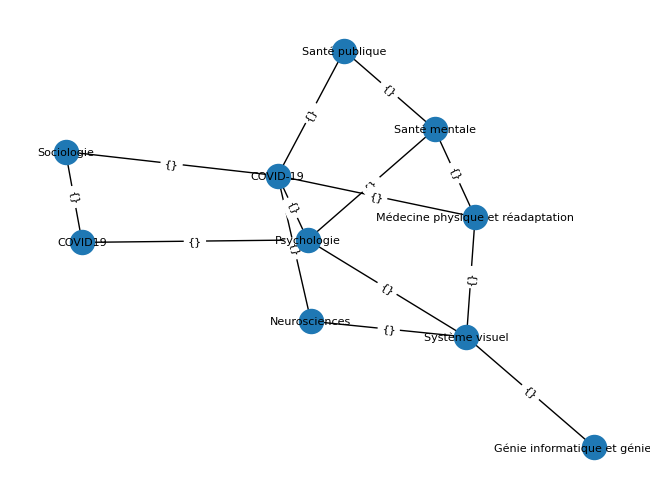

In [41]:
# Draw the graph
pos = nx.spring_layout(nx_graph)  # Choose a layout algorithm
labels = {node: node for node in nx_graph.nodes()}
nx.draw(nx_graph, pos, with_labels=True, labels=labels, font_size=8)
nx.draw_networkx_edge_labels(nx_graph, pos, font_size=8)

# Display the plot
plt.show()

In [ ]:
graphs = {}
departements = expertises
listeDepartements = departements['département'].unique().tolist()

for departement in listeDepartements:
    nx_graph = nx.Graph()

    subdf = departements[departements['département'] == departement]
    ### Département 
    records = subdf.to_dict('records')
    
    ## Pour chaque discipline associée au département
    for record in records:
        listeDisciplines = subdf['expertise.disciplines.nom'].unique().tolist()

        for discipline in listeDisciplines:
            subsubdf = subdf[subdf['expertise.disciplines.nom'] == discipline]

            rrecords = subsubdf.to_dict('records')

            s = discipline
            nx_graph.add_node(s)

            # Fréquence 
            #compte = freqDisciplines[record['expertise.motsCles.nom']]

            ## Pour chaque mot-clé associé à la discipline
            for rrecord in rrecords:
                motCle = record['expertise.motsCles.nom']
                o = motCle
                nx_graph.add_node(o)
            
                ### Fréquence
                #compte = freqMotsCles[record['expertise.motsCles.nom']]

                # Lien discipline <> mot-clé
                nx_graph.add_edge(s, o)


    graphs[departement] = nx_graph

*On va essayer de visualiser chaque graphe avec networkx et plotly*

In [ ]:
nx_graph = graphs['Département de neurosciences']
nx_graph

In [ ]:
# Draw the graph
pos = nx.spring_layout(nx_graph)  # Choose a layout algorithm
labels = {node: node.split("/")[-1] for node in nx_graph.nodes()}
nx.draw(nx_graph, pos, with_labels=True, labels=labels, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(nx_graph, pos, font_size=8)

# Display the plot
plt.show()

In [ ]:
# Exemple de visualisation qui pourrait être utilisée avec le graphe permettant de cartographier les expertises de recherche

import networkx as nx
import plotly.graph_objects as go

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5])

# Add edges
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1)])

# Define node sizes (you can replace this with your desired sizes)
node_sizes = [10, 20, 30, 40, 50]

# Create a Plotly figure
fig = go.Figure()

# Add nodes and edges to the Plotly figure
pos = nx.spring_layout(G)  # You can use a different layout algorithm
edge_trace = go.Scatter(x=[], y=[], line={'width': 0.5, 'color': '#888'})
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += (x0, x1, None)
    edge_trace['y'] += (y0, y1, None)

node_trace = go.Scatter(
    x=[], y=[], text=[], mode='markers+text', hoverinfo='text',
    marker={'size': node_sizes, 'color': '#FF5733'}
)
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)

fig.add_trace(edge_trace)
fig.add_trace(node_trace)

# Customize layout to hide grid and remove axis
fig.update_layout(
    xaxis_visible=False,  # Hide x-axis
    yaxis_visible=False  # Hide y-axis
)

# Show the Plotly figure
fig.show()